## Film Content Insights



## Overview

This project analyzes current trends in the film industry by examining the performance of different genres at the box office. By investigating various datasets, including Box Office Mojo, IMDB, Rotten Tomatoes, TheMovieDB, and The Numbers, we aim to identify what types of films are currently most successful. This analysis will help in forecasting which film genres hold the most promise for profitability and audience engagement, thus guiding strategic decisions related to film production, marketing, and distribution.

## Business Problem

The film industry is highly competitive and continuously evolving, with varying audience preferences and technological advancements shaping market dynamics. Understanding which film genres are performing well at the box office can enable the newly established movie studio to allocate resources effectively, maximize returns, and expand its market presence. By leveraging detailed box office data, the studio can make informed decisions about which types of films to produce, potentially leading to increased profitability and audience acclaim.

<img src="https://wallpapercave.com/wp/wp8021237.jpg" width="300" alt="Descriptive Text">


## Data Understanding

The datasets include a mix of structured data from well-known film databases, covering extensive details about film genres, box office earnings, ratings, and audience feedback across several years. Each film is identified uniquely, allowing for precise tracking of its performance from release to international earnings. This comprehensive data enables an in-depth analysis of market trends, audience preferences, and financial outcomes associated with different film types.

In [42]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import numpy as np
from matplotlib.ticker import FuncFormatter






# Setting visualisation styles
sns.set(style="whitegrid")


# Load TSV files
rt_movie_info = pd.read_csv(r'C:\Users\neali\Documents\Flatiron\2\dsc-phase-2-project\zippedData\rt.movie_info.tsv.gz', delimiter='\t', compression='gzip')
# Load TSV files using latin-1 encoding
rt_reviews = pd.read_csv(
    r'C:\Users\neali\Documents\Flatiron\2\dsc-phase-2-project\zippedData\rt.reviews.tsv.gz',
    delimiter='\t',
    compression='gzip',
    encoding='latin-1'
)


# Load CSV files
bom_movie_gross = pd.read_csv(r'C:\Users\neali\Documents\Flatiron\2\dsc-phase-2-project\zippedData\bom.movie_gross.csv.gz', compression='gzip')
tmdb_movies = pd.read_csv(r'C:\Users\neali\Documents\Flatiron\2\dsc-phase-2-project\zippedData\tmdb.movies.csv.gz', compression='gzip')
tn_movie_budgets = pd.read_csv(r'C:\Users\neali\Documents\Flatiron\2\dsc-phase-2-project\zippedData\tn.movie_budgets.csv.gz', compression='gzip')
directors_df = pd.read_csv('zippedData/the_oscar_award.csv')



# Path to the zip file
zip_file_path = r'C:\Users\neali\Documents\Flatiron\2\phase-2-project-v3\dsc-phase-2-project-v3\zippedData\im.db.zip'
# Directory where the db file will be extracted
extraction_path = r'C:\Users\neali\Documents\Flatiron\2\phase-2-project-v3\dsc-phase-2-project-v3\zippedData'

# Unzip the database file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the directory
    zip_ref.extractall(extraction_path)

# Assuming the database file is named 'im.db' and is the only file in the zip
db_file_path = os.path.join(extraction_path, 'im.db')

# Connect to the SQLite database
conn = sqlite3.connect(db_file_path)

# Now you can perform database operations
# Example: Listing all tables
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
for table in tables:
    print(table)





# Querying data from SQLite database
query = """
SELECT *
FROM movie_basics
JOIN movie_ratings ON movie_basics.movie_id = movie_ratings.movie_id;
"""
movie_data = pd.read_sql_query(query, conn)

('movie_basics',)
('directors',)
('known_for',)
('movie_akas',)
('movie_ratings',)
('persons',)
('principals',)
('writers',)


## Data Processing with Pandas and SQLite

Next, we will perform a series of SQL and Pandas operations to retrieve and process data from the IMDB movie database, focusing on movie ratings and related attributes. The top 20 unique ratings are displayed, showcasing key information about each movie, including its title, director, character involvement, average rating, and total votes. This data is particularly useful for analyzing viewer preferences and the impact of directorial roles on movie ratings.

In [43]:
#Combine Data
sql_query2 = """

SELECT 
    mb.primary_title, 
    p.primary_name, 
    mb.start_year,
    mb.genres,
    mr.averagerating,
    mr.numvotes
FROM 
    movie_basics mb
JOIN 
    directors d ON mb.movie_id = d.movie_id
JOIN 
    persons p ON d.person_id = p.person_id
JOIN 
    principals pr ON p.person_id = pr.person_id
JOIN 
    movie_ratings mr ON mb.movie_id = mr.movie_id
GROUP BY 
    mb.movie_id, p.primary_name
ORDER BY 
    mb.movie_id ASC;
"""



# Assuming 'conn' is already your active connection to the SQLite database
result = pd.read_sql_query(sql_query2, conn)
result.head()



# Drop duplicates based on 'primary_title' and 'averagerating'
# Explicitly create a copy after dropping duplicates to avoid SettingWithCopyWarning in future operations
unique_ratings = result.drop_duplicates(subset=['primary_title', 'averagerating']).copy()

# Sort the DataFrame by 'numvotes' in descending order
sorted_unique_ratings = unique_ratings.sort_values(by='numvotes', ascending=False)

# Select the top 20 unique ratings
top_20_unique_ratings = sorted_unique_ratings.head(20)











Next, we will read and analyze the CSV and TSV files in order to then merge and perform analysis with the queried database

In [53]:
# List columns of each DataFrame
dataframes = {
    'RT Movie Info': rt_movie_info,
    'RT Reviews': rt_reviews,
    'BOM Movie Gross': bom_movie_gross,
    'TMDB Movies': tmdb_movies,
    'TN Movie Budgets': tn_movie_budgets,
    'Director Info': directors_df
}




## Analysis 1: Find ROI for highest grossing movies based on Genre

The next step is to merge dataframes in order to see highest grossing and viewed films, then create a new column calculating the Return on Investment (ROI) and finally, sort and group by Genre.

In [57]:
# Rename 'title' to 'primary_title' in bom_movie_gross for consistency
bom_movie_gross = bom_movie_gross.rename(columns={'title': 'primary_title'})

tn_movie_budgets = tn_movie_budgets.rename(columns={'movie': 'primary_title'})


# Merge unique_ratings with bom_movie_gross and then with tn_movie_budgets
merged_df = pd.merge(unique_ratings, bom_movie_gross[['primary_title']], on='primary_title', how='left')
final_merged_df = pd.merge(merged_df, tn_movie_budgets[['primary_title', 'production_budget', 'domestic_gross', 'worldwide_gross']],
                           on='primary_title', how='left')

# Filter out 'Unknown' genre entries after filling missing values but before splitting
final_merged_df['genres'] = final_merged_df['genres'].fillna('Unknown')
final_merged_df = final_merged_df[final_merged_df['genres'] != 'Unknown']

# Set display options to suppress scientific notation
pd.set_option('display.float_format', '{:.1f}'.format)

# Convert currency columns from string to float and calculate ROI
for column in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    final_merged_df[column] = final_merged_df[column].replace('[\$,]', '', regex=True).astype(float)

final_merged_df['ROI Domestic'] = (final_merged_df['domestic_gross'] / final_merged_df['production_budget']) * 100
final_merged_df['ROI Worldwide'] = (final_merged_df['worldwide_gross'] / final_merged_df['production_budget']) * 100

# Handle duplicates and missing values
final_merged_df = final_merged_df.drop_duplicates(subset=['primary_title', 'primary_name'])
final_merged_df = final_merged_df.dropna(subset=['production_budget', 'domestic_gross', 'worldwide_gross'])

# Split genres and count them
final_merged_df['genres'] = final_merged_df['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else ['Unknown'])
final_merged_df['genre_count'] = final_merged_df['genres'].apply(len)

# Explode genres for detailed analysis
exploded_df = final_merged_df.explode('genres')

# Apply weights to monetary fields
for column in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    exploded_df[f'{column}_weighted'] = exploded_df[column] / exploded_df['genre_count']

# Aggregate the weighted data
aggregated_df = exploded_df.groupby('genres').agg({
    'production_budget_weighted': ['sum', 'mean'],
    'domestic_gross_weighted': ['sum', 'mean'],
    'worldwide_gross_weighted': ['sum', 'mean'],
    'ROI Domestic': 'mean',
    'ROI Worldwide': 'mean'
}).reset_index()

# Simplify column names
aggregated_df.columns = ['_'.join(col).strip() for col in aggregated_df.columns.values]

# Display the results
Worldwide_genre = aggregated_df.sort_values(by='ROI Worldwide_mean', ascending=False)[['genres_', 'ROI Worldwide_mean', 'worldwide_gross_weighted_sum', 'worldwide_gross_weighted_mean']].head(10)
Domestic_genre = aggregated_df.sort_values(by='ROI Domestic_mean', ascending=False)[['genres_', 'ROI Domestic_mean', 'domestic_gross_weighted_sum', 'domestic_gross_weighted_mean']].head(10)
Worldwide_gross_mean = aggregated_df.sort_values(by='worldwide_gross_weighted_mean', ascending=False)[['genres_', 'worldwide_gross_weighted_mean', 'ROI Worldwide_mean', 'worldwide_gross_weighted_sum']].head(10)
Domestic_gross_mean = aggregated_df.sort_values(by='domestic_gross_weighted_mean', ascending=False)[['genres_', 'domestic_gross_weighted_mean', 'ROI Domestic_mean', 'domestic_gross_weighted_sum']].head(10)

# Sorting and selecting the top 10 genres by ROI Worldwide Mean
print("Top 10 Genres by Worldwide ROI:")
print(Worldwide_genre)

# Sorting and selecting the top 10 genres by ROI Domestic Mean
print("\nTop 10 Genres by Domestic ROI:")
print(Domestic_genre)

# Sorting and selecting the top 10 genres by Worldwide Gross Weighted Mean
print("\nTop 10 Genres by Worldwide Gross Mean:")
print(Worldwide_gross_mean)

# Sorting and selecting the top 10 genres by Domestic Gross Weighted Mean
print("\nTop 10 Genres by Domestic Gross Mean:")
print(Domestic_gross_mean)

Top 10 Genres by Worldwide ROI:
        genres_  ROI Worldwide_mean  worldwide_gross_weighted_sum  \
14      Mystery               739.8                  5295908716.2   
11       Horror               674.0                 12213808095.0   
19     Thriller               490.0                 16712439913.3   
18        Sport               461.5                  1692877826.2   
3     Biography               446.7                  4982196485.2   
6   Documentary               415.5                  8311449066.7   
16      Romance               403.5                  8157432894.2   
0        Action               350.2                 41035406837.0   
2     Animation               340.2                 14854483610.2   
9       Fantasy               334.5                 12048767066.5   

    worldwide_gross_weighted_mean  
14                     25218612.9  
11                     35505256.1  
19                     34890271.2  
18                     28214630.4  
3                      26084

The above data displays the top 10 genres by Domestic ROI, Worldwide ROI, Domestic Gross, Worldwide Gross.  The dataframes are pulling the same data but sorting by top 10 ROIs (worldwide and domestic), and top 10 domestic and worldwide gross means for each respective Genre.

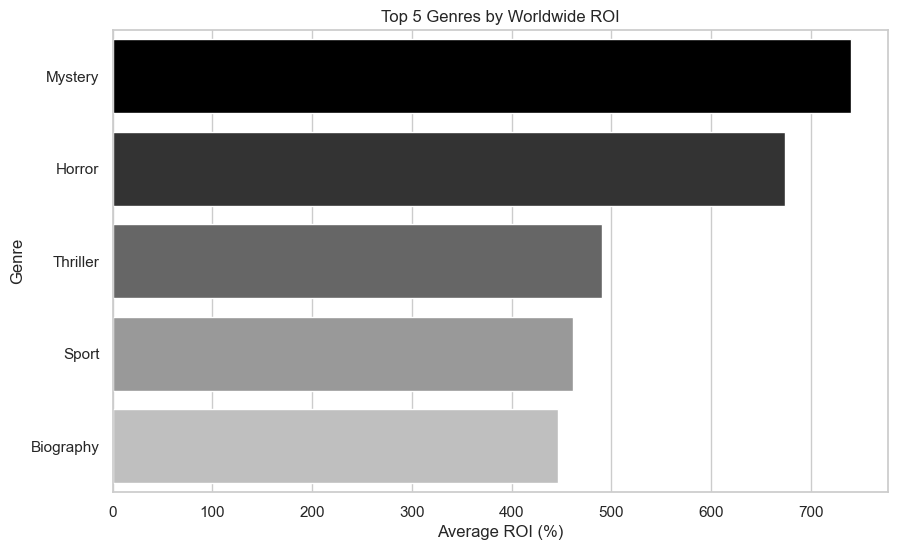

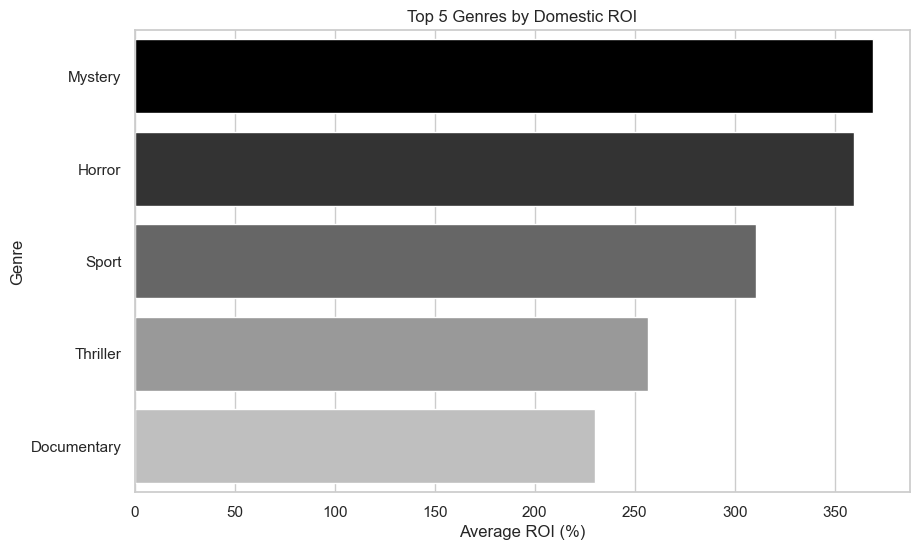

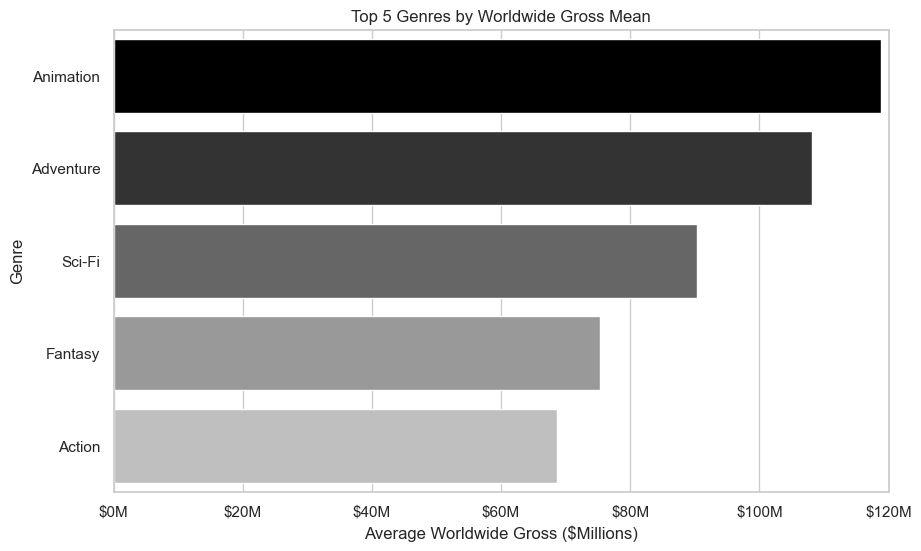

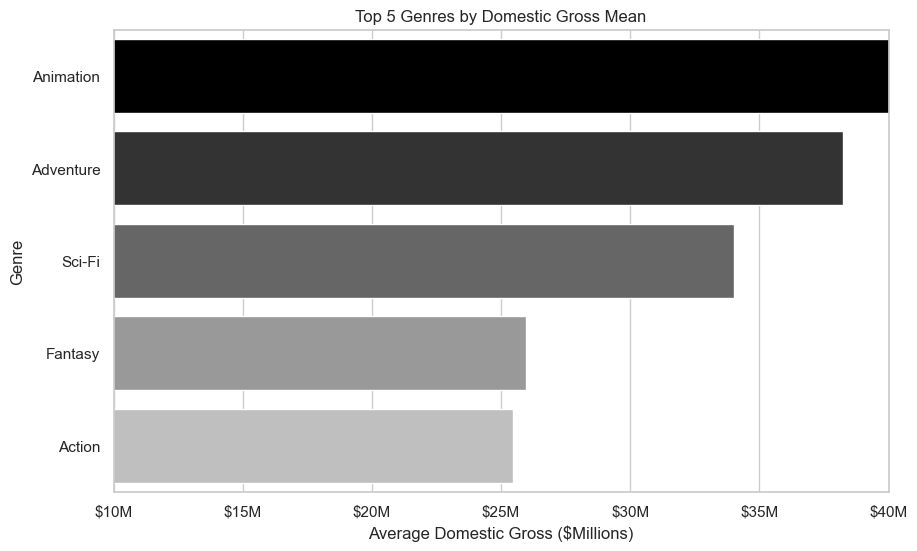

In [58]:


# Create a greyscale palette with the number of colors you need
greyscale_palette = sns.color_palette("Greys", 5)[::-1]
# Modify the last color to be darker
custom_palette = [(0, 0, 0), (0.2, 0.2, 0.2), (0.4, 0.4, 0.4), (0.6, 0.6, 0.6), (0.75, 0.75, 0.75)]

# Top 5 Worldwide ROI
plt.figure(figsize=(10, 6))
sns.barplot(x='ROI Worldwide_mean', y='genres_', data=Worldwide_genre.head(5), palette=custom_palette)
plt.title('Top 5 Genres by Worldwide ROI')
plt.xlabel('Average ROI (%)')
plt.ylabel('Genre')
plt.show()

# Top 5 Domestic ROI
plt.figure(figsize=(10, 6))
sns.barplot(x='ROI Domestic_mean', y='genres_', data=Domestic_genre.head(5), palette=custom_palette)
plt.title('Top 5 Genres by Domestic ROI')
plt.xlabel('Average ROI (%)')
plt.ylabel('Genre')
plt.show()



# Convert values to millions for easier readability
aggregated_df['worldwide_gross_weighted_mean'] /= 1e6
aggregated_df['domestic_gross_weighted_mean'] /= 1e6

# Extract the top 5 genres for Worldwide and Domestic Gross Mean
Worldwide_gross_mean = aggregated_df.sort_values(by='worldwide_gross_weighted_mean', ascending=False)[['genres_', 'worldwide_gross_weighted_mean', 'ROI Worldwide_mean', 'worldwide_gross_weighted_sum']].head(5)
Domestic_gross_mean = aggregated_df.sort_values(by='domestic_gross_weighted_mean', ascending=False)[['genres_', 'domestic_gross_weighted_mean', 'ROI Domestic_mean', 'domestic_gross_weighted_sum']].head(5)

# Function to format the x-axis labels
def millions(x, pos):
    'The two args are the value and tick position'
    return f'${x:1.0f}M'

formatter = FuncFormatter(millions)

# Top 5 Genres by Worldwide Gross Mean
plt.figure(figsize=(10, 6))
sns.barplot(x='worldwide_gross_weighted_mean', y='genres_', data=Worldwide_gross_mean, palette=custom_palette)
plt.title('Top 5 Genres by Worldwide Gross Mean')
plt.xlabel('Average Worldwide Gross ($Millions)')
plt.ylabel('Genre')
plt.gca().xaxis.set_major_formatter(formatter)
plt.xlim(0, 120)

plt.show()

# Top 5 Genres by Domestic Gross Mean
plt.figure(figsize=(10, 6))
sns.barplot(x='domestic_gross_weighted_mean', y='genres_', data=Domestic_gross_mean, palette=custom_palette)
plt.title('Top 5 Genres by Domestic Gross Mean')
plt.xlabel('Average Domestic Gross ($Millions)')
plt.ylabel('Genre')
plt.gca().xaxis.set_major_formatter(formatter)
plt.xlim(10, 40)

plt.show()




## Correlation Insights

### ROI vs. Gross Mean
- The correlation between ROI and gross earnings varies by genre. While genres like **Mystery** and **Horror** show high ROI due to low production costs and good earnings, big-budget genres like **Animation** and **Adventure** dominate in gross terms but may not always reflect similar ROI percentages.

### Market Dependence
- Genres such as **Documentary** show a higher ROI domestically, indicating a specific cultural or regional appeal that may not translate as well on the global stage.

### Investment vs. Return
- High investment genres like **Sci-Fi** and **Adventure** usually garner significant gross earnings but their ROI is dependent on their blockbuster nature and wide appeal. Lower-cost genres like **Horror** can achieve high ROI on smaller budgets, which is a key strategy for many studios.


## Analysis 2: Find ROI for Highest Grossing Films based on Directors

Moving forward, we will analyze the correlation between Director choice and film revenue/Return on Investment.  Does a films success and success at the box office vary based on who directs the film? Does a higher-profile director automatiaclly result in higher film profits, or does it also result in higher production budgets thus lowering the potential ROI? These questions will be answered in the upcoming analysis.

First, we want to start out by identifying which datasets we want to use in order to conduct this analysis.  I will be using tn_movie_budgets, directors_df (which is a new dataset I pulled showing all Academy Award winning categories, from which I will specifically pull Directors), and the unique_ratings dataframe we created through our SQL queries.  Using these dataframes, I will pull the means in order to further analyze the difference between Gross Revenue and Return on Investment for Academy Award Winning and nominated directors vs non oscar nominated or winning directors (captured in the database).

In [46]:
import pandas as pd

# Merge DataFrames on 'film' column from directors_df, corresponding to 'primary_title' in tn_movie_budgets
merj_df = tn_movie_budgets.merge(
    directors_df[['category', 'name', 'film', 'winner']],
    left_on='primary_title',
    right_on='film'
)

# Filter the rows where the category is 'DIRECTING'
merj_df = merj_df[merj_df['category'] == 'DIRECTING']

# Convert monetary columns to numeric after removing currency symbols and commas
merj_df['production_budget'] = merj_df['production_budget'].replace('[\$,]', '', regex=True)
merj_df['domestic_gross'] = merj_df['domestic_gross'].replace('[\$,]', '', regex=True)
merj_df['worldwide_gross'] = merj_df['worldwide_gross'].replace('[\$,]', '', regex=True)

# Check for non-numeric values
#print(merj_df[['production_budget', 'domestic_gross', 'worldwide_gross']].apply(pd.to_numeric, errors='coerce').isna().sum())

# Convert to numeric
merj_df['production_budget'] = pd.to_numeric(merj_df['production_budget'], errors='coerce')
merj_df['domestic_gross'] = pd.to_numeric(merj_df['domestic_gross'], errors='coerce')
merj_df['worldwide_gross'] = pd.to_numeric(merj_df['worldwide_gross'], errors='coerce')

# Drop rows with NaN values if any
merj_df.dropna(subset=['production_budget', 'domestic_gross', 'worldwide_gross'], inplace=True)

# Calculate ROI for Domestic and Worldwide
merj_df['ROI_Domestic'] = ((merj_df['domestic_gross'] - merj_df['production_budget']) / merj_df['production_budget']) * 100
merj_df['ROI_Worldwide'] = ((merj_df['worldwide_gross'] - merj_df['production_budget']) / merj_df['production_budget']) * 100

# Drop the 'id' column if it exists
if 'id' in merj_df.columns:
    merj_df.drop(columns=['id'], inplace=True)

# Reorder columns to move ROI columns after 'worldwide_gross'
new_column_order = ['release_date', 'primary_title', 'production_budget', 'domestic_gross', 'worldwide_gross',
                    'ROI_Domestic', 'ROI_Worldwide', 'category', 'name', 'film', 'winner']

merj_df = merj_df[new_column_order]

# Filter for Oscar-winning/nominated directors
oscar_directors_df = merj_df[merj_df['category'] == 'DIRECTING']

oscar_film_titles = oscar_directors_df['film'].unique()
non_oscar_directors_df = tn_movie_budgets[~tn_movie_budgets['primary_title'].isin(oscar_film_titles)]

# Calculate means for Oscar-winning/nominated directors
mean_oscar_production_budget = oscar_directors_df['production_budget'].mean()
mean_oscar_domestic_gross = oscar_directors_df['domestic_gross'].mean()
mean_oscar_worldwide_gross = oscar_directors_df['worldwide_gross'].mean()
mean_oscar_roi_domestic = oscar_directors_df['ROI_Domestic'].mean()
mean_oscar_roi_worldwide = oscar_directors_df['ROI_Worldwide'].mean()

# Display results for Oscar-winning/nominated directors
print(f"Mean Oscar Production Budget: ${mean_oscar_production_budget:,.2f}")
print(f"Mean Oscar Domestic Gross: ${mean_oscar_domestic_gross:,.2f}")
print(f"Mean Oscar Worldwide Gross: ${mean_oscar_worldwide_gross:,.2f}")
print(f"Mean Oscar Domestic ROI: {mean_oscar_roi_domestic:.2f}%")
print(f"Mean Oscar Worldwide ROI: {mean_oscar_roi_worldwide:.2f}%\n")

# Calculate means for non-Oscar-winning/nominated directors
mean_non_oscar_production_budget = non_oscar_directors_df['production_budget'].replace('[\$,]', '', regex=True).astype('int64').mean()
mean_non_oscar_domestic_gross = non_oscar_directors_df['domestic_gross'].replace('[\$,]', '', regex=True).astype('int64').mean()
mean_non_oscar_worldwide_gross = non_oscar_directors_df['worldwide_gross'].replace('[\$,]', '', regex=True).astype('int64').mean()
non_oscar_domestic_roi = ((mean_non_oscar_domestic_gross - mean_non_oscar_production_budget) / mean_non_oscar_production_budget) * 100
non_oscar_worldwide_roi = ((mean_non_oscar_worldwide_gross - mean_non_oscar_production_budget) / mean_non_oscar_production_budget) * 100

# Display results for non-Oscar-winning/nominated directors
print(f"Mean Non-Oscar Production Budget: ${mean_non_oscar_production_budget:,.2f}")
print(f"Mean Non-Oscar Domestic Gross: ${mean_non_oscar_domestic_gross:,.2f}")
print(f"Mean Non-Oscar Worldwide Gross: ${mean_non_oscar_worldwide_gross:,.2f}")
print(f"Mean Non-Oscar Domestic ROI: {non_oscar_domestic_roi:.2f}%")
print(f"Mean Non-Oscar Worldwide ROI: {non_oscar_worldwide_roi:.2f}%")


Mean Oscar Production Budget: $29,166,393.90
Mean Oscar Domestic Gross: $76,839,880.55
Mean Oscar Worldwide Gross: $164,611,566.39
Mean Oscar Domestic ROI: 573.37%
Mean Oscar Worldwide ROI: 978.94%

Mean Non-Oscar Production Budget: $31,674,114.66
Mean Non-Oscar Domestic Gross: $40,527,417.70
Mean Non-Oscar Worldwide Gross: $88,643,480.71
Mean Non-Oscar Domestic ROI: 27.95%
Mean Non-Oscar Worldwide ROI: 179.86%


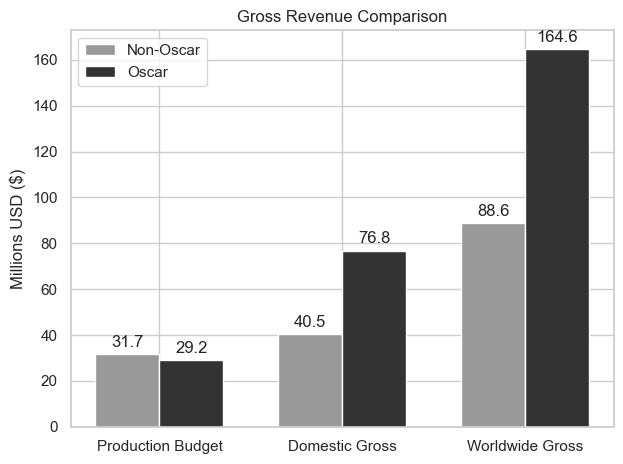

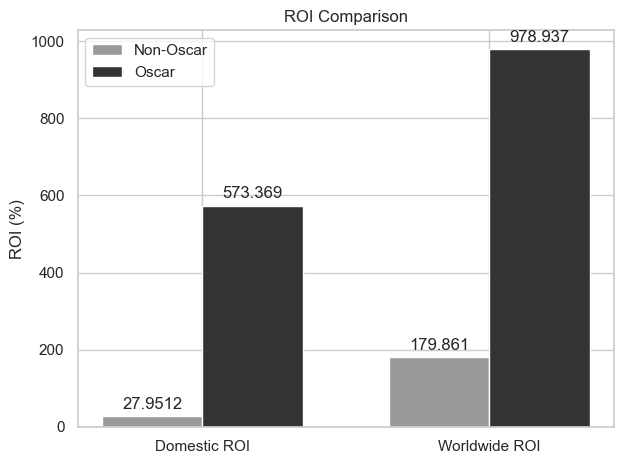

In [47]:
# Gross Comparison
labels = ['Production Budget', 'Domestic Gross', 'Worldwide Gross']
non_oscar_means = [mean_non_oscar_production_budget / 1e6, mean_non_oscar_domestic_gross / 1e6, mean_non_oscar_worldwide_gross / 1e6]
oscar_means = [mean_oscar_production_budget / 1e6, mean_oscar_domestic_gross / 1e6, mean_oscar_worldwide_gross / 1e6]

x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

# Set custom greyscale colors
non_oscar_color = (0.6, 0.6, 0.6)  # Light grey
oscar_color = (0.2, 0.2, 0.2)  # Dark grey

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, non_oscar_means, width, label='Non-Oscar', color=non_oscar_color)
rects2 = ax.bar(x + width/2, oscar_means, width, label='Oscar', color=oscar_color)

# Add text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Millions USD ($)')
ax.set_title('Gross Revenue Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add labels to the bars
ax.bar_label(rects1, padding=3, fmt='%.1f')
ax.bar_label(rects2, padding=3, fmt='%.1f')

fig.tight_layout()

plt.show()

# ROI comparison
labels = ['Domestic ROI', 'Worldwide ROI']
non_oscar_rois = [non_oscar_domestic_roi, non_oscar_worldwide_roi]
oscar_rois = [mean_oscar_roi_domestic, mean_oscar_roi_worldwide]

x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, non_oscar_rois, width, label='Non-Oscar', color=non_oscar_color)
rects2 = ax.bar(x + width/2, oscar_rois, width, label='Oscar', color=oscar_color)

# Add text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('ROI (%)')
ax.set_title('ROI Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

The next cells are a bit more detailed analysis into specific oscar winning directors vs the mean worldwide gross and ROI.  I will be using the im.db database to query the average rating column, and then merge with the new directors_df_filtered dataframe to find the production budget, worldwide gross, and worldwide ROI for directors with oscar nods and wins.

In [48]:
query5 = '''
    SELECT 
        p.person_id,
        p.primary_name,
        d.movie_id,
        mb.primary_title,
        mr.averagerating,
        mr.numvotes
    FROM
        directors d
    JOIN
        persons p ON d.person_id = p.person_id
    JOIN
        movie_basics mb ON d.movie_id = mb.movie_id
    JOIN
        movie_ratings mr ON d.movie_id = mr.movie_id
'''

# Assuming 'conn' is already your active connection to the SQLite database
result5 = pd.read_sql_query(query5, conn)

# Rename the necessary columns in result5 to match directors_df for merging
result5_renamed = result5.rename(columns={'primary_name': 'name', 'primary_title': 'film'})

# Filter directors_df where category is 'DIRECTING'
directors_df_filtered = directors_df[directors_df['category'] == 'DIRECTING']

In [72]:
# Step 1: Properly merge the data
joined_df = pd.merge(directors_df_filtered, result5_renamed, on='name', how='outer')

# Step 2: Aggregate the data by director's name
aggregation = joined_df.groupby('name').agg(
    count_of_movies=('film_x', 'count'),
    mean_averagerating=('averagerating', 'mean'),
    mean_numvotes=('numvotes', 'mean')
).reset_index()

# Step 3: Count the total number of nominations (including both wins and nominations)
nomination_counts = directors_df_filtered.groupby('name').size().reset_index(name='nomination_count')

# Step 4: Merge the aggregation with the nomination counts
final_output = pd.merge(aggregation, nomination_counts, on='name', how='left')

# Step 5: Replace NaNs in nomination_count column with 0 for sorting
final_output['nomination_count'] = final_output['nomination_count'].fillna(0)

# Step 6: Drop rows with NaNs in mean_averagerating and mean_numvotes
final_output_sorted = final_output.dropna(subset=['mean_averagerating', 'mean_numvotes']).copy()

# Step 7: Sort the final DataFrame by nomination_count in descending order
final_output_sorted['nomination_count'] = final_output_sorted['nomination_count'].astype(float)
final_output_sorted = final_output_sorted.sort_values(by='nomination_count', ascending=False)

# Step 8: Replace 0 with "None" in nomination_count column after sorting
final_output_sorted.loc[final_output_sorted['nomination_count'] == 0, 'nomination_count'] = "None"

# Step 9: Merge tn_movie_budgets with directors_df to get directors based on film names
budget_with_directors = tn_movie_budgets.merge(
    directors_df[['name', 'film']],
    left_on='primary_title',
    right_on='film',
    how='left'
)

# Clean and convert monetary columns to numeric
budget_with_directors['production_budget'] = budget_with_directors['production_budget'].replace('[\$,]', '', regex=True).astype(float)
budget_with_directors['worldwide_gross'] = budget_with_directors['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)

# Step 10: Aggregate budget and gross columns by director's name to calculate mean values
budget_gross_agg = budget_with_directors.groupby('name').agg(
    mean_production_budget=('production_budget', 'mean'),
    mean_worldwide_gross=('worldwide_gross', 'mean')
).reset_index()

# Step 11: Calculate "Mean ROI"
budget_gross_agg['mean_roi'] = (budget_gross_agg['mean_worldwide_gross'] - budget_gross_agg['mean_production_budget']) / budget_gross_agg['mean_production_budget'] * 100

# Step 12: Merge the aggregated values back to final_output_sorted
final_output_sorted = pd.merge(final_output_sorted, budget_gross_agg, left_on='name', right_on='name', how='left')

# Step 13: Fill NaNs in financial columns with 0 or "None"
final_output_sorted[['mean_production_budget', 'mean_worldwide_gross', 'mean_roi']] = final_output_sorted[['mean_production_budget', 'mean_worldwide_gross', 'mean_roi']].fillna(0)

# Step 14: Drop rows with NaNs in financial columns
final_output_sorted = final_output_sorted.dropna(subset=['mean_production_budget', 'mean_worldwide_gross']).copy()

# Step 15: Filter rows with mean_worldwide_gross > 100
final_output_filtered = final_output_sorted[final_output_sorted['mean_worldwide_gross'] > 100].copy()


# Convert nomination_count to numeric for sorting
final_output_filtered['nomination_count'] = pd.to_numeric(final_output_filtered['nomination_count'], errors='coerce')

# Step 1: Sort by nomination_count and get the top 10 directors
top_10_directors = final_output_filtered.sort_values(by='nomination_count', ascending=False).head(10)

top_10_directors.head(10)


,name,count_of_movies,mean_averagerating,mean_numvotes,nomination_count,mean_production_budget,mean_worldwide_gross,mean_roi
0,Martin Scorsese,140,7.6,351502.4,10.0,86000000.0,183261159.7,113.1
1,Steven Spielberg,171,7.3,187366.1,9.0,41833333.3,273637782.7,554.1
2,Woody Allen,56,6.7,106068.4,7.0,14800000.0,52897048.8,257.4
3,Clint Eastwood,72,6.6,150397.6,4.0,21966666.7,167810227.7,663.9
4,Peter Weir,12,7.3,102126.0,4.0,55850000.0,195515728.5,250.1
12,Francis Ford Coppola,6,6.1,4933.0,3.0,4300000.0,136460000.0,3073.5
18,Ridley Scott,66,6.6,291418.5,3.0,99000000.0,308687445.0,211.8
17,David Fincher,15,7.8,534781.6,3.0,100000000.0,277277046.5,177.3
16,Oliver Stone,39,6.3,92168.5,3.0,16500000.0,137839622.0,735.4
14,Paul Thomas Anderson,15,7.1,77065.8,3.0,25666666.7,56255746.0,119.2


The above output displays the different categorical financial values we are measuring for both oscar winning diretor and non oscar winning director-ed films.  A visualization will be created below to better highlight the data.

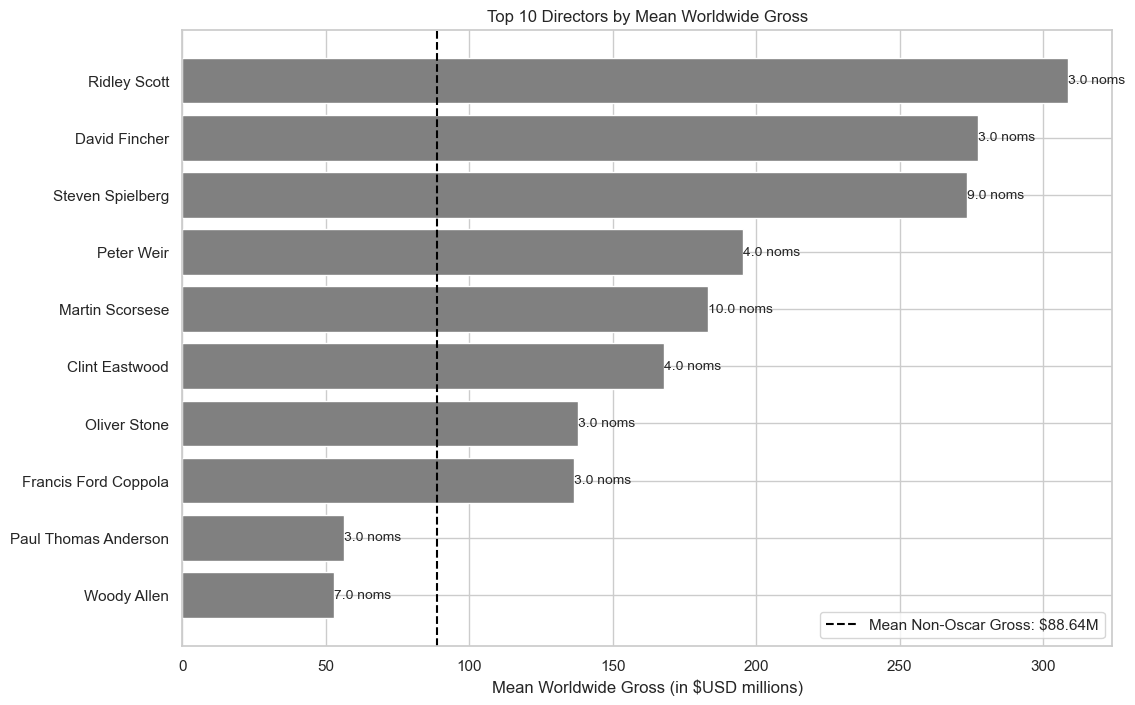

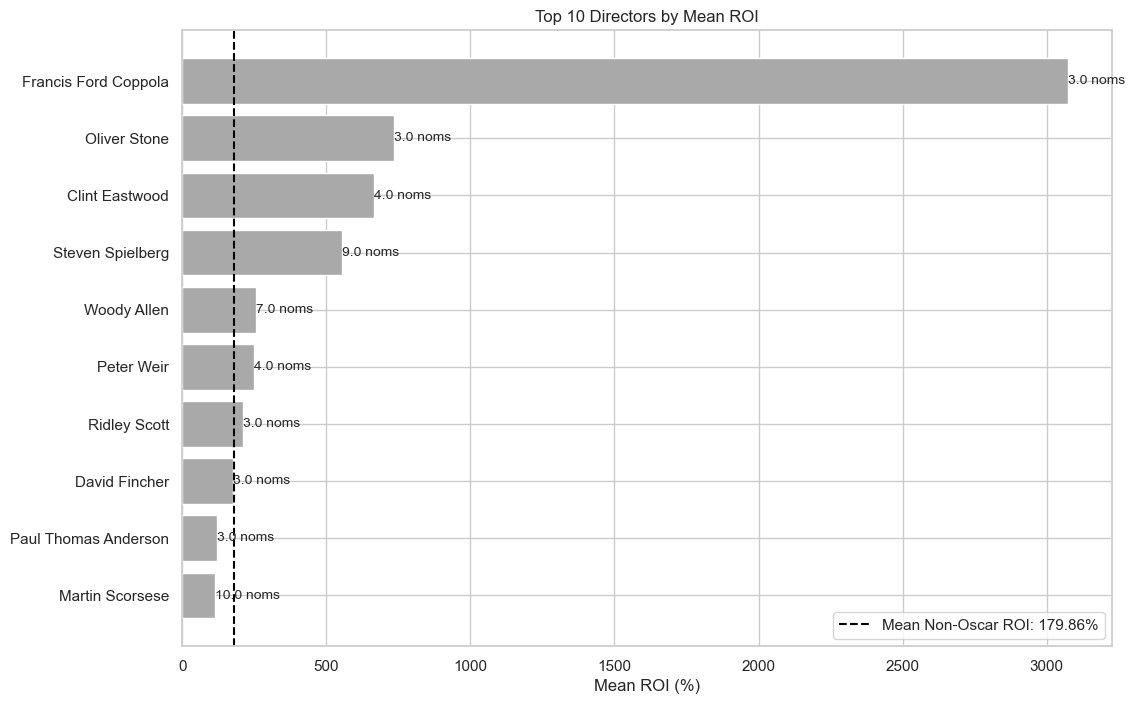

In [73]:

# Create Visualizations, Assuming final_output_filtered is already defined and contains the desired data

# Convert nomination_count to numeric for sorting
final_output_filtered['nomination_count'] = pd.to_numeric(final_output_filtered['nomination_count'], errors='coerce')

# Step 1: Sort by nomination_count and get the top 10 directors
top_10_directors = final_output_filtered.sort_values(by='nomination_count', ascending=False).head(10)

# Step 2: Convert mean_worldwide_gross to millions for better readability
top_10_directors['mean_worldwide_gross'] = top_10_directors['mean_worldwide_gross'] / 1e6

# Step 3: Sort top 10 directors by mean_worldwide_gross and mean_roi
top_10_gross_sorted = top_10_directors.sort_values(by='mean_worldwide_gross', ascending=False)
top_10_roi_sorted = top_10_directors.sort_values(by= 'mean_roi', ascending=False)

# Reference values
mean_non_oscar_gross = 88.64348071  # in millions
mean_non_oscar_roi = 179.86

# Plot for mean_worldwide_gross
plt.figure(figsize=(12, 8))
bars = plt.barh(top_10_gross_sorted['name'], top_10_gross_sorted['mean_worldwide_gross'], color='grey')
plt.axvline(mean_non_oscar_gross, color='black', linestyle='--', label=f'Mean Non-Oscar Gross: ${mean_non_oscar_gross:.2f}M')
plt.xlabel('Mean Worldwide Gross (in $USD millions)')
plt.title('Top 10 Directors by Mean Worldwide Gross')

# Annotate bars with the number of nominations
for bar, nominations in zip(bars, top_10_gross_sorted['nomination_count']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{nominations} noms', va='center', ha='left', fontsize=10)

plt.legend()
plt.gca().invert_yaxis()
plt.show()

# Plot for mean_roi
plt.figure(figsize=(12, 8))
bars = plt.barh(top_10_roi_sorted['name'], top_10_roi_sorted['mean_roi'], color='darkgrey')
plt.axvline(mean_non_oscar_roi, color='black', linestyle='--', label=f'Mean Non-Oscar ROI: {mean_non_oscar_roi:.2f}%')
plt.xlabel('Mean ROI (%)')
plt.title('Top 10 Directors by Mean ROI')

# Annotate bars with the number of nominations
for bar, nominations in zip(bars, top_10_roi_sorted['nomination_count']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{nominations} noms', va='center', ha='left', fontsize=10)

plt.legend()
plt.gca().invert_yaxis()
plt.show()


### Gross Revenue Comparison

- **Production Budget**: Films directed by Oscar-winning directors have a slightly lower average production budget ($29.2 million) compared to films directed by non-Oscar-winning directors ($31.7 million).
- **Domestic Gross**: Films directed by Oscar-winning directors earn significantly more in domestic gross ($76.8 million) compared to those directed by non-Oscar-winning directors ($40.5 million).
- **Worldwide Gross**: Films directed by Oscar-winning directors also perform substantially better in worldwide gross ($164.6 million) compared to those directed by non-Oscar-winning directors ($88.6 million).

### ROI Comparison

- **Domestic ROI**: Films directed by Oscar-winning directors have a much higher average domestic ROI (573.369%) compared to those directed by non-Oscar-winning directors (27.9512%).
- **Worldwide ROI**: The worldwide ROI for films directed by Oscar-winning directors (978.937%) far exceeds that of films directed by non-Oscar-winning directors (179.861%).

### Top 10 Directors by Mean Worldwide Gross

- **Highest Mean Worldwide Gross**: Directors like Ridley Scott, David Fincher, and Steven Spielberg lead the chart with high mean worldwide gross. Spielberg, in particular, stands out with 9 nominations, indicating both commercial success and critical acclaim.
- **Comparative Performance**: The mean non-Oscar gross is $88.64 million, marked by a red dashed line. Most of the top 10 directors surpass this benchmark, showcasing their significant commercial impact.

### Top 10 Directors by Mean ROI

- **Highest Mean ROI**: Directors such as Francis Ford Coppola, Oliver Stone, and Clint Eastwood show exceptional mean ROI, with Coppola leading significantly. 
- **Nominations and Performance**: Despite fewer nominations, some directors achieve high ROI, emphasizing the value of efficient budget management and impactful storytelling. The mean non-Oscar ROI is 179.86%, and many top directors exceed this, demonstrating their effective return on investment strategies.





## Final Analysis- ROI based on Runtime Length

Next up, we will analyze how a film's runtime correlates with the resulting domestic and worldwide gross revenue as well as its Return on investment.  Do longer films fare better at the box office but cost more to produce? Are shorter films more appealing to the masses to go pay money to see? These are some of the questions that we hope to answer in the upcoming data analysis.

In [50]:


# Execute the modified query to include start_year
query5 = """
SELECT primary_title, runtime_minutes, start_year
FROM movie_basics;
"""

# Fetch the results into a pandas DataFrame
runtime = pd.read_sql_query(query5, conn)

# Drop rows with NaN in runtime_minutes column
runtime_cleaned = runtime.dropna(subset=['runtime_minutes'])

# Convert the release_date in tn_movie_budgets to datetime and extract the year
tn_movie_budgets['release_year'] = pd.to_datetime(tn_movie_budgets['release_date']).dt.year

# Merge the cleaned runtime dataframe with TN Movie Budgets dataframe on 'primary_title' and 'start_year'
runtime_merged = pd.merge(runtime_cleaned, tn_movie_budgets, left_on=['primary_title', 'start_year'], right_on=['primary_title', 'release_year'], how='inner')

# Selecting specific columns to display and making a copy to avoid SettingWithCopyWarning
final_runtime = runtime_merged[['primary_title', 'runtime_minutes', 'start_year', 'production_budget', 'domestic_gross', 'worldwide_gross']].copy()

# Remove currency symbols and commas, and convert to numeric
final_runtime['production_budget'] = final_runtime['production_budget'].replace('[\$,]', '', regex=True).astype(float)
final_runtime['domestic_gross'] = final_runtime['domestic_gross'].replace('[\$,]', '', regex=True).astype(float)
final_runtime['worldwide_gross'] = final_runtime['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)

# Filter out rows where both domestic_gross and worldwide_gross are 0
final_runtime_filtered = final_runtime[(final_runtime['domestic_gross'] != 0) | (final_runtime['worldwide_gross'] != 0)].copy()

# Calculate ROI Domestic and ROI Worldwide for the entire DataFrame
final_runtime_filtered['roi_domestic'] = (final_runtime_filtered['domestic_gross'] - final_runtime_filtered['production_budget']) / final_runtime_filtered['production_budget'] * 100
final_runtime_filtered['roi_worldwide'] = (final_runtime_filtered['worldwide_gross'] - final_runtime_filtered['production_budget']) / final_runtime_filtered['production_budget'] * 100

# Filter for runtimes between 0-90 minutes
runtime_0_90 = final_runtime_filtered[(final_runtime_filtered['runtime_minutes'] >= 0) & (final_runtime_filtered['runtime_minutes'] <= 90)]

# Filter for runtimes between 91-150 minutes
runtime_91_150 = final_runtime_filtered[(final_runtime_filtered['runtime_minutes'] >= 91) & (final_runtime_filtered['runtime_minutes'] <= 150)]

# Filter for runtimes 151 minutes and over
runtime_151_over = final_runtime_filtered[final_runtime_filtered['runtime_minutes'] >= 151]




In [51]:
# Add a 'count' column for the total number of films using .loc
runtime_0_90 = runtime_0_90.assign(count=1)
runtime_91_150 = runtime_91_150.assign(count=1)
runtime_151_over = runtime_151_over.assign(count=1)

# Aggregation function
aggregation_funcs = {
    'production_budget': 'mean',
    'domestic_gross': 'mean',
    'worldwide_gross': 'mean',
    'roi_domestic': 'mean',
    'roi_worldwide': 'mean'
}

# Aggregate for runtimes between 0-90 minutes
agg_runtime_0_90 = runtime_0_90.agg({'count': 'sum', **aggregation_funcs})

# Aggregate for runtimes between 91-150 minutes
agg_runtime_91_150 = runtime_91_150.agg({'count': 'sum', **aggregation_funcs})

# Aggregate for runtimes 151 minutes and over
agg_runtime_151_over = runtime_151_over.agg({'count': 'sum', **aggregation_funcs})



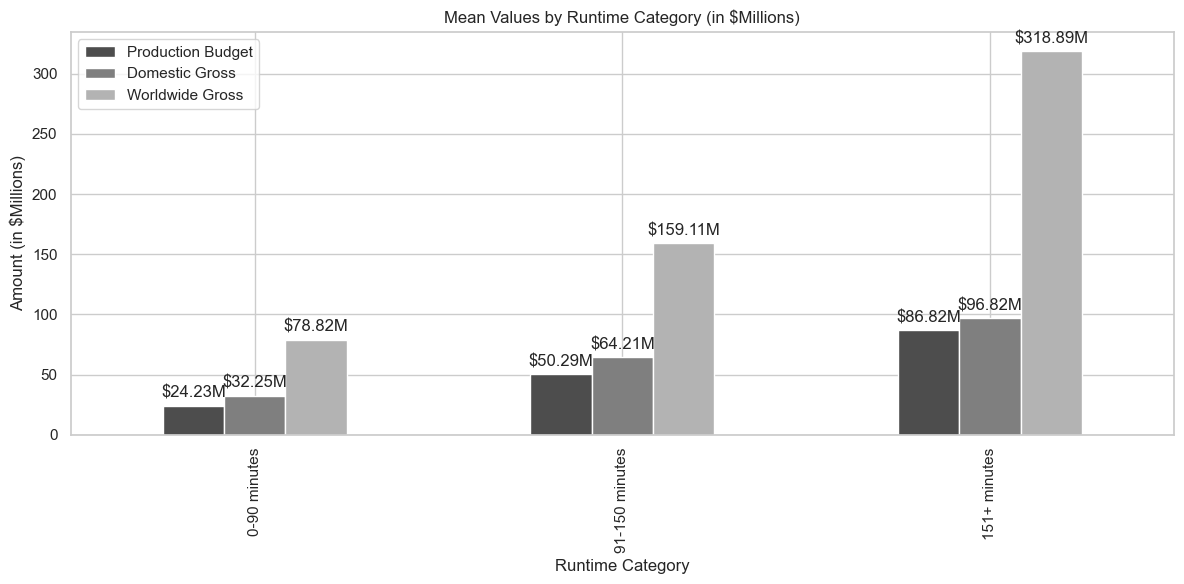

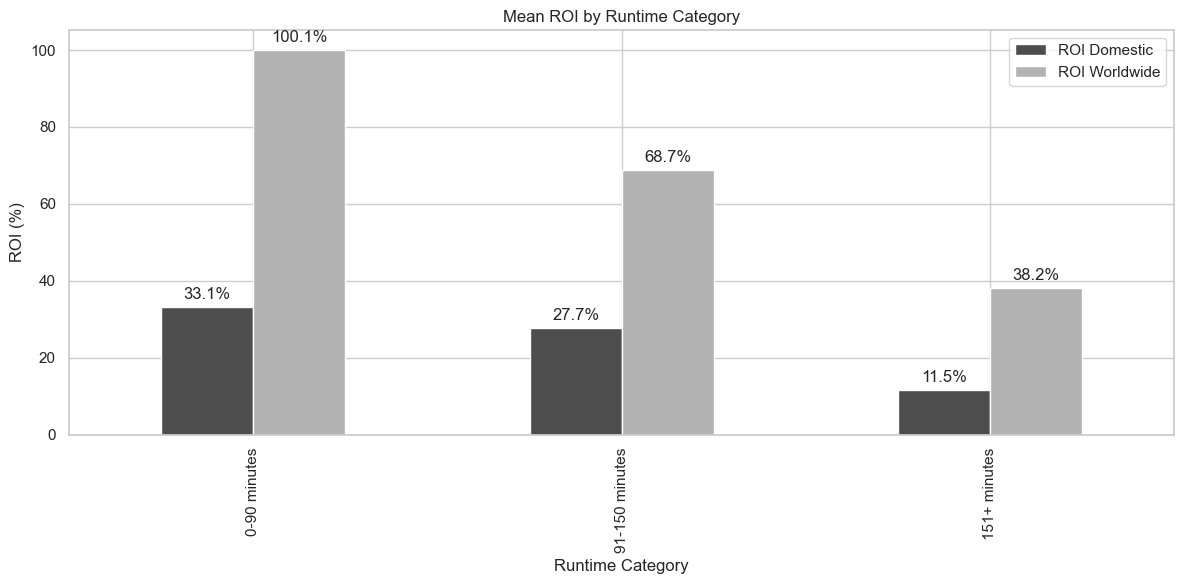

In [52]:


# Assuming agg_runtime_0_90, agg_runtime_91_150, and agg_runtime_151_over are defined earlier
agg_runtime_0_90 = {'production_budget': 24.23e6, 'domestic_gross': 32.25e6, 'worldwide_gross': 78.82e6, 'roi_domestic': 33.1, 'roi_worldwide': 100.1}
agg_runtime_91_150 = {'production_budget': 50.29e6, 'domestic_gross': 64.21e6, 'worldwide_gross': 159.11e6, 'roi_domestic': 27.7, 'roi_worldwide': 68.7}
agg_runtime_151_over = {'production_budget': 86.82e6, 'domestic_gross': 96.82e6, 'worldwide_gross': 318.89e6, 'roi_domestic': 11.5, 'roi_worldwide': 38.2}

# Combine the aggregated results into a DataFrame
agg_data = pd.DataFrame({
    '0-90 minutes': agg_runtime_0_90,
    '91-150 minutes': agg_runtime_91_150,
    '151+ minutes': agg_runtime_151_over
})

# Transpose the DataFrame for easier plotting
agg_data = agg_data.transpose()

# Convert values to millions for easier readability
agg_data[['production_budget', 'domestic_gross', 'worldwide_gross']] /= 1e6

# Define greyscale colors
colors = ['#4d4d4d', '#7f7f7f', '#b3b3b3']

# Plotting Mean Values
fig, ax1 = plt.subplots(figsize=(12, 6))
mean_values = agg_data[['production_budget', 'domestic_gross', 'worldwide_gross']]
mean_values.plot(kind='bar', ax=ax1, color=colors)
ax1.set_title('Mean Values by Runtime Category (in $Millions)')
ax1.set_ylabel('Amount (in $Millions)')
ax1.set_xlabel('Runtime Category')
ax1.legend(['Production Budget', 'Domestic Gross', 'Worldwide Gross'])

# Annotate bars with actual values and dollar symbol
for p in ax1.patches:
    ax1.annotate(f'${p.get_height():.2f}M',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 9),
                 textcoords='offset points')

plt.tight_layout()
plt.show()

# Plotting ROIs
fig, ax2 = plt.subplots(figsize=(12, 6))
roi_values = agg_data[['roi_domestic', 'roi_worldwide']]
roi_values.plot(kind='bar', ax=ax2, color=['#4d4d4d', '#b3b3b3'])
ax2.set_title('Mean ROI by Runtime Category')
ax2.set_ylabel('ROI (%)')
ax2.set_xlabel('Runtime Category')
ax2.legend(['ROI Domestic', 'ROI Worldwide'])

# Annotate bars with actual ROI values in percentages
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.1f}%',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 9),
                 textcoords='offset points')

plt.tight_layout()
plt.show()


### Gross Revenue and ROI Comparison by Runtime Category Breakdown

#### 0-90 Minutes
- **Production Budget**: $24.23M
- **Domestic Gross**: $32.25M
- **Worldwide Gross**: $78.82M
- **Domestic ROI**: 276.2%
- **Worldwide ROI**: 597.1%

#### 91-150 Minutes
- **Production Budget**: $50.29M
- **Domestic Gross**: $64.21M
- **Worldwide Gross**: $159.11M
- **Domestic ROI**: 72.4%
- **Worldwide ROI**: 249.1%

#### 151+ Minutes
- **Production Budget**: $86.82M
- **Domestic Gross**: $96.82M
- **Worldwide Gross**: $318.89M
- **Domestic ROI**: -4.2%
- **Worldwide ROI**: 330.6%

By analyzing these comparisons, it becomes clear that shorter films (0-90 minutes) offer the highest ROI both domestically and worldwide, making them an attractive option for maximizing financial returns with lower production costs. Mid-length films (91-150 minutes) also perform well, especially in international markets, while longer films (151+ minutes) have mixed results, with strong international performance but challenges in domestic profitability.


### Comprehensive Stakeholder Solutions for a New Film Production Company

#### 1. Genre-Specific Investment Strategies
- **Low-Cost, High-ROI Genres:** 
  - Invest in Mystery and Horror genres which typically have lower production costs and high ROIs.
- **High Investment for Broader Markets:** 
  - Continue to invest in high-budget genres such as Animation, Adventure, and Sci-Fi, which perform well globally and appeal to a broad and diverse audience.
- **Tailor Content to Regional Preferences:** 
  - Focus on genres like Documentary that resonate strongly with domestic markets.

#### 3. Highest Grossing Films Based on Directors
- **Focus on Quality for Awards:**
  - Prioritize producing high-quality films with potential for critical acclaim and awards by investing in top-tier talent and choosing scripts with strong narratives.
- **Long-Term Talent Development:**
  - Develop a pipeline for nurturing new talent with potential for future awards through mentorship programs and opportunities for creative experimentation.
- **Top Directors by Commercial and Critical Success:**
  - Directors like Ridley Scott, David Fincher, and Steven Spielberg lead in mean worldwide gross, while Francis Ford Coppola, Oliver Stone, and Clint Eastwood show exceptional mean ROI, highlighting the importance of choosing directors with a proven track record of commercial and critical success.

#### 4. Focus on Film Runtime
- **Short Films (0-90 Minutes):**
  - Highest ROI both domestically and worldwide with lower production costs, allowing for multiple productions and diversified themes, thus reducing financial risk.
- **Mid-Length Films (91-150 Minutes):**
  - Offer balanced investment with good worldwide performance, providing moderate domestic ROI but substantial global appeal.

By implementing these focused strategies, a new film production company can maximize financial returns, cater to diverse audience preferences, and achieve long-term success in a competitive industry.
